
#Problem Statement#
The problem is to find out which is spam mail and which is ham mail.

Importing All libraries that we will need and use through the notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from wordcloud import WordCloud
import string
from collections import Counter
from nltk.corpus import stopwords

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import joblib
import pickle
%matplotlib inline

In [10]:
df=pd.read_csv('drive/MyDrive/Colab Notebooks/csvdata/spam.csv', encoding='latin-1')

Reading the dataset

In [11]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#Data Cleaning#

In [12]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)

In [13]:
df = df.rename({"v1":"Category", "v2":"Message"}, axis=1)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [16]:
# Checking for redundancy
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
5567    False
5568    False
5569    False
5570    False
5571    False
Length: 5572, dtype: bool

In [17]:
df.shape

(5572, 2)

In [18]:
# Droping the redundant data
df = df.drop_duplicates()

In [19]:
df.shape

(5169, 2)

In [20]:
df.describe()

,Category,Message
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


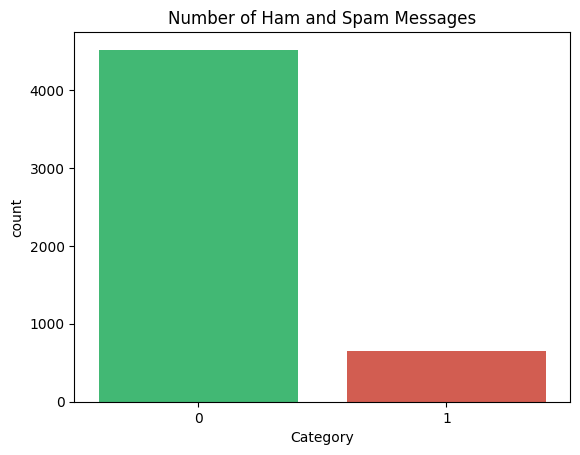

In [44]:
#plotting the ham and spam messages to understand the distribution
custom_colors = ["#2ecc71", "#e74c3c"]  # Green for 'ham' and Red for 'spam'

# Creating the count plot
sns.countplot(data=df, x='Category', palette=custom_colors)

# Setting labels and title
plt.xlabel('Category')
plt.title('Number of Ham and Spam Messages')

# Showing the plot
plt.show()


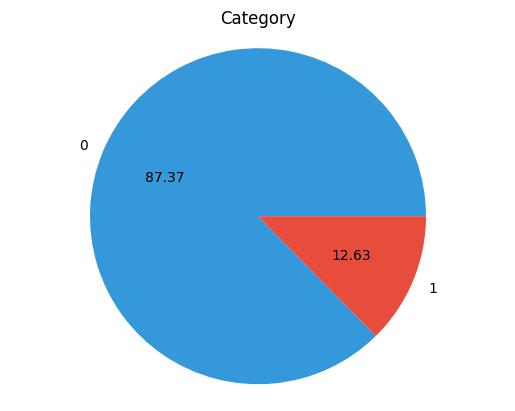

In [45]:

# Defining meaningful colors for the pie chart
custom_colors = ['#3498db', '#e74c3c']  # Blue for 'ham' and Red for 'spam'

# Creating the pie chart
df.groupby('Category').size().plot(kind='pie', autopct='%.2f', colors=custom_colors, title="Category")

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Showing the plot
plt.show()


#Text Preprocessing#

In [23]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Initializing stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Defining function to preprocess text
def preprocess_text(text):
    # Converting to lowercase
    text = text.lower()
    # Removing punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Stem
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens]
    # Joining tokens back into text string
    preprocessed_text = " ".join(stemmed_tokens)
    return preprocessed_text

# Apply preprocessing function to 'Message' column
df['Message'] = df['Message'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
df.head()

,Category,Message
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think go usf life around though


#Creating a model that fits the data#

In [27]:
# Label Encode The Target Variable
encode = LabelEncoder()
df.Category = encode.fit_transform(df.Category)

In [28]:
df.head()

,Category,Message
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri 2 wkli comp win fa cup final tkt 21...
3,0,u dun say earli hor u c alreadi say
4,0,nah dont think go usf life around though


In [29]:
x_train, x_test, y_train, y_test = train_test_split(df['Message'], df["Category"], test_size = 0.2, random_state = 0)

Feature Extraction using BoW feature

In [30]:
# Generating the bag-of-words features
vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [31]:
# storing the vectorizer object in a separate pickle file
pickle.dump(vectorizer, open('count_vectorizer.pkl', 'wb'))

Logistic Regression Model

In [32]:
LR = LogisticRegression()
LR.fit(x_train,y_train)
predict = LR.predict(x_test)
print(classification_report(y_test, predict))
LRAcc = accuracy_score(predict,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LRAcc*100))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       885
           1       0.99      0.86      0.92       149

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034

Logistic Regression accuracy is: 97.87%


Confusion Matrix for Logistic Regression

Confusion Matrix for Logistic Regression :
 [[884   1]
 [ 21 128]] 



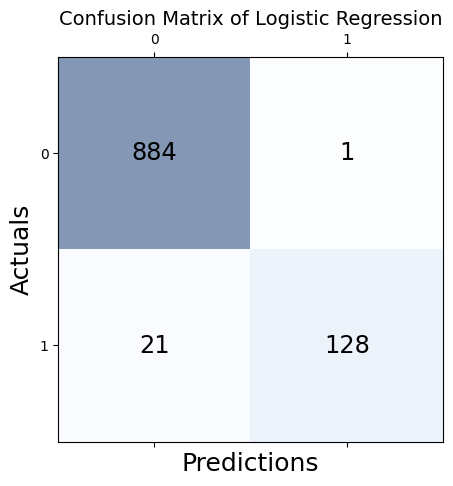

In [33]:
# Confusion Matrix for Logistic Regression
cm = metrics.confusion_matrix(y_test, predict)
print('Confusion Matrix for Logistic Regression :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of Logistic Regression', fontsize=14)
plt.show()

SVC Model

In [34]:
svc = SVC(kernel="linear")
svc.fit(x_train,y_train)
predict_svc = svc.predict(x_test)
print(classification_report(y_test, predict_svc))
SVCAcc = accuracy_score(predict_svc,y_test)
print('SVC model accuracy is: {:.2f}%'.format(SVCAcc*100))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       885
           1       0.96      0.87      0.91       149

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034

SVC model accuracy is: 97.58%


Confusion Matrix for SVC Model

Confusion Matrix for SVC :
 [[880   5]
 [ 20 129]] 



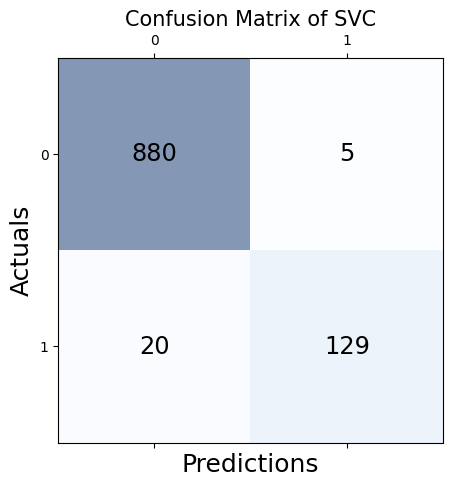

In [35]:
cm = metrics.confusion_matrix(y_test, predict_svc)
print('Confusion Matrix for SVC :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of SVC', fontsize=15)
plt.show()

ID3 Model

In [36]:
DT = DecisionTreeClassifier(max_depth=(1), random_state=0)
DT.fit(x_train,y_train)
predict_ID3 = DT.predict(x_test)
print(classification_report(y_test, predict_ID3))
ID3Acc = accuracy_score(predict_svc,y_test)
print('ID3 model accuracy is: {:.2f}%'.format(ID3Acc*100))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       885
           1       0.62      0.40      0.49       149

    accuracy                           0.88      1034
   macro avg       0.77      0.68      0.71      1034
weighted avg       0.86      0.88      0.87      1034

ID3 model accuracy is: 97.58%


Confusion Matrix for ID3 Model

Confusion Matrix for ID3 :
 [[849  36]
 [ 89  60]] 



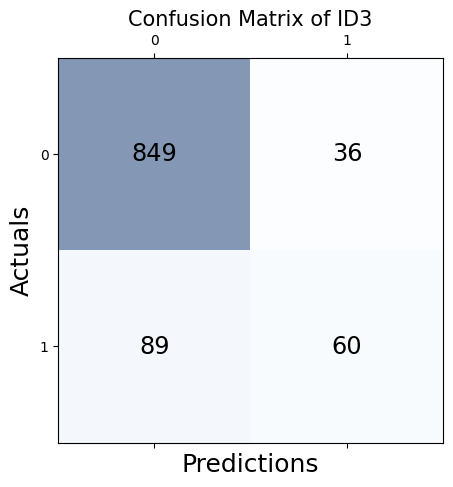

In [37]:
cm = metrics.confusion_matrix(y_test, predict_ID3)
print('Confusion Matrix for ID3 :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of ID3', fontsize=15)
plt.show()

Random Forest Model

In [38]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)
y_pred_rf = clf.predict(x_test)
print(classification_report(y_test, y_pred_rf))
rfAcc = accuracy_score(y_pred_rf,y_test)
print('Random Forest model accuracy is: {:.2f}%'.format(rfAcc*100))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       885
           1       1.00      0.82      0.90       149

    accuracy                           0.97      1034
   macro avg       0.99      0.91      0.94      1034
weighted avg       0.97      0.97      0.97      1034

Random Forest model accuracy is: 97.39%


Confusion Matrix for Random Forest

Confusion Matrix for Random Forest :
 [[885   0]
 [ 27 122]] 



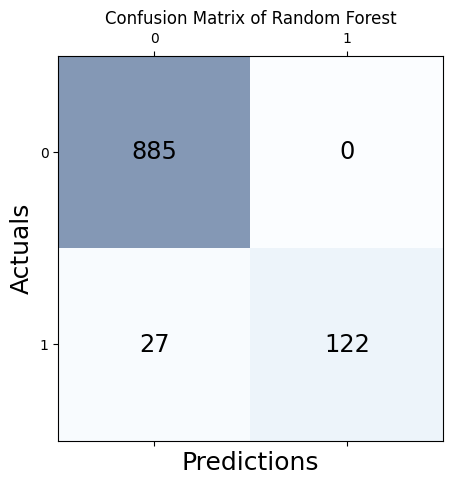

In [39]:
cm = metrics.confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix for Random Forest :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of Random Forest', fontsize=12)
plt.show()

Multinomial Naive Bayes Model

In [40]:
# Train a Naive Bayes classifier
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred_naive = nb.predict(x_test)
print(classification_report(y_test, y_pred_naive))
naiveAcc = accuracy_score(y_pred_naive,y_test)
print('Naive Bayes model accuracy is: {:.2f}%'.format(naiveAcc*100))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       885
           1       0.97      0.87      0.92       149

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034

Naive Bayes model accuracy is: 97.78%


Confusion Matrix for Multinomial Naive Bayes Model

Confusion Matrix for Random Forest :
 [[881   4]
 [ 19 130]] 



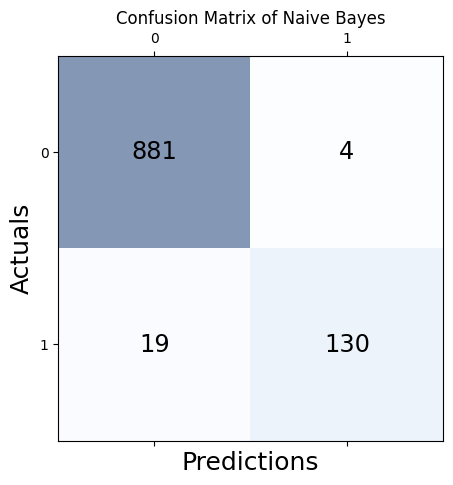

In [41]:
cm = metrics.confusion_matrix(y_test, y_pred_naive)
print('Confusion Matrix for Random Forest :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of Naive Bayes', fontsize=12)
plt.show()

Loading the Multinomial Naive Bayes Model

In [42]:
joblib_file = "model_NB"
joblib.dump(nb, joblib_file)
loaded_model = joblib.load(open(joblib_file, 'rb'))
pred_y = loaded_model.predict(x_test)
result = np.round(accuracy_score(y_test, pred_y), 2)
print(result)

0.98
